In [ ]:
# 1. IMPORT LIBRARIES
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report,
                             roc_curve, auc)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance
import joblib

In [ ]:
# LOAD DATASET
df = pd.read_csv('/content/diabetes.csv')

BASIC EDA

In [ ]:
# BASIC EDA
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
df.tail()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1
767,1,93,70,31,0,30.4,0.315,23,0


In [ ]:
# Quick info
df.shape, df.info(), df.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


((768, 9),
 None,
                           count        mean         std     min       25%  \
 Pregnancies               768.0    3.845052    3.369578   0.000   1.00000   
 Glucose                   768.0  120.894531   31.972618   0.000  99.00000   
 BloodPressure             768.0   69.105469   19.355807   0.000  62.00000   
 SkinThickness             768.0   20.536458   15.952218   0.000   0.00000   
 Insulin                   768.0   79.799479  115.244002   0.000   0.00000   
 BMI                       768.0   31.992578    7.884160   0.000  27.30000   
 DiabetesPedigreeFunction  768.0    0.471876    0.331329   0.078   0.24375   
 Age                       768.0   33.240885   11.760232  21.000  24.00000   
 Outcome                   768.0    0.348958    0.476951   0.000   0.00000   
 
                                50%        75%     max  
 Pregnancies                 3.0000    6.00000   17.00  
 Glucose                   117.0000  140.25000  199.00  
 BloodPressure              7

In [ ]:
# 3. BASIC EDA - target distribution and missing values
print("Columns:", df.columns.tolist())
print("\nTarget distribution:\n", df['Outcome'].value_counts(normalize=False))
print("\nMissing values per column:\n", df.isna().sum())


Columns: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

Target distribution:
 Outcome
0    500
1    268
Name: count, dtype: int64

Missing values per column:
 Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [ ]:
# Show number of zeros for key columns
cols_with_zero = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
(df[cols_with_zero]==0).sum()

,0
Glucose,5
BloodPressure,35
SkinThickness,227
Insulin,374
BMI,11


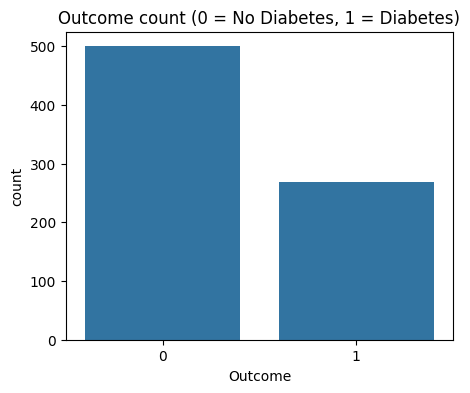

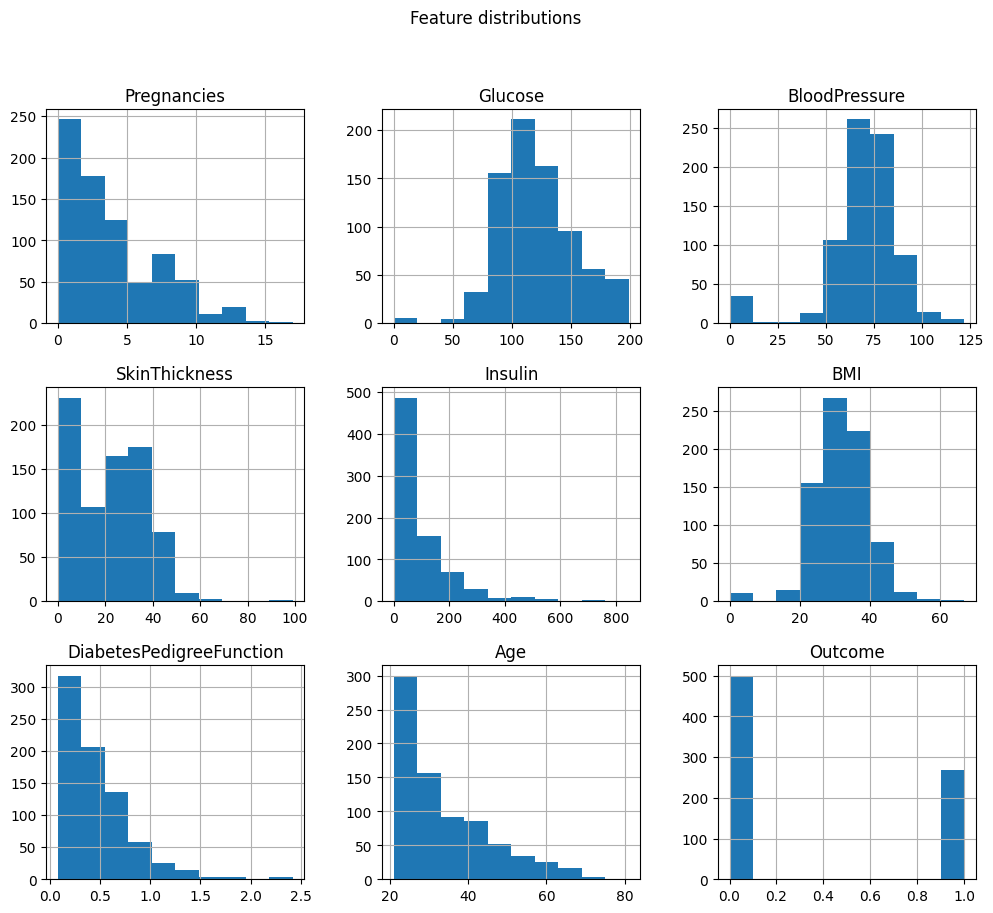

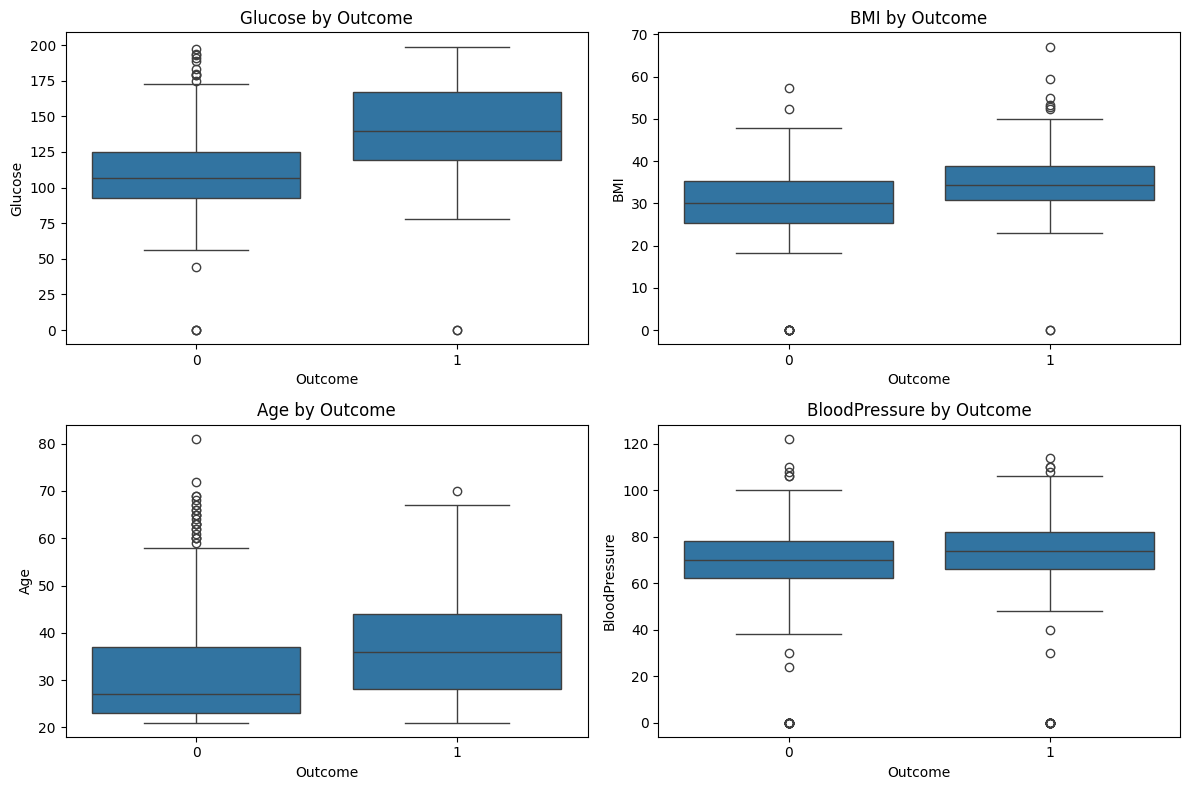

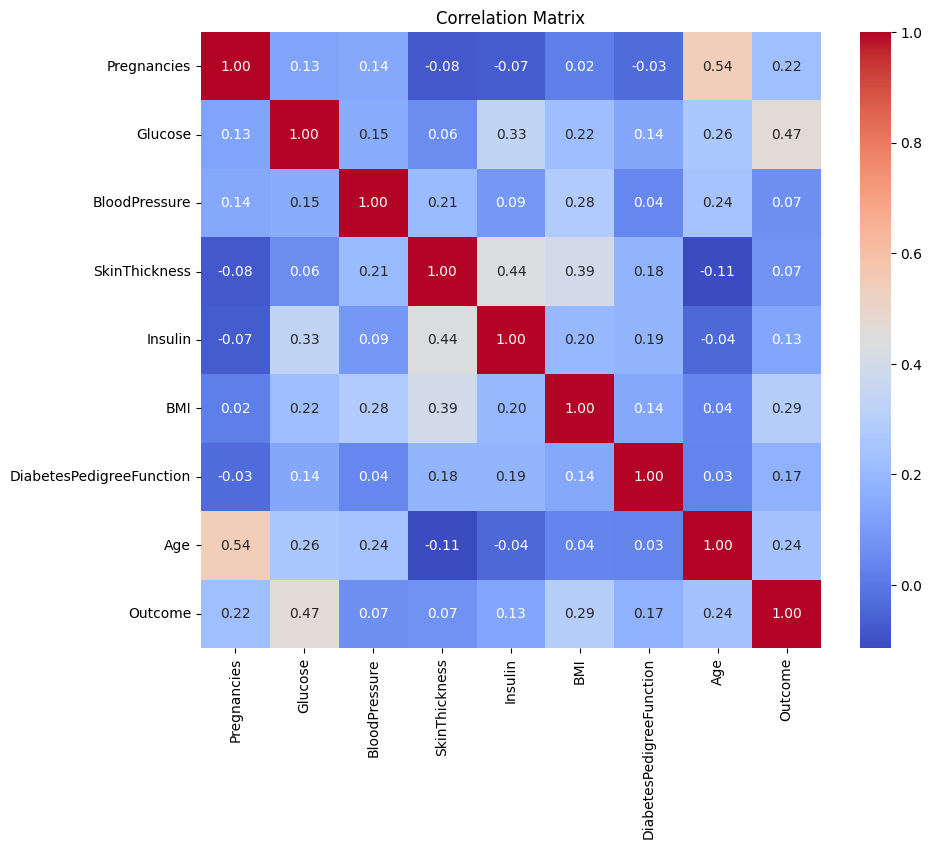

In [ ]:
# 4. VISUALIZATIONS

# 4.1 Outcome counts
plt.figure(figsize=(5,4))
sns.countplot(x='Outcome', data=df)
plt.title('Outcome count (0 = No Diabetes, 1 = Diabetes)')
plt.show()

# 4.2 Histograms for all numeric features
df.hist(figsize=(12,10))
plt.suptitle('Feature distributions')
plt.show()

# 4.3 Boxplots by Outcome for some important features
features = ['Glucose','BMI','Age','BloodPressure']
plt.figure(figsize=(12,8))
for i, col in enumerate(features,1):
    plt.subplot(2,2,i)
    sns.boxplot(x='Outcome', y=col, data=df)
    plt.title(f'{col} by Outcome')
plt.tight_layout()
plt.show()

# 4.4 Correlation matrix
plt.figure(figsize=(10,8))
corr = df.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [ ]:
# 5. PREPROCESSING
# Treat zeros in certain columns as missing
df_copy = df.copy()
missing_cols = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']

# Replace zeros with NaN for those columns
df_copy[missing_cols] = df_copy[missing_cols].replace(0, np.nan)
df_copy.isna().sum()

,0
Pregnancies,0
Glucose,5
BloodPressure,35
SkinThickness,227
Insulin,374
BMI,11
DiabetesPedigreeFunction,0
Age,0
Outcome,0


In [ ]:
# Impute missing values using median (robust for outliers)
num_cols = df_copy.columns.drop('Outcome')
imputer = SimpleImputer(strategy='median')

# post-imputation stats:
df_imputed = df_copy.copy()
df_imputed[num_cols] = imputer.fit_transform(df_imputed[num_cols])
df_imputed.isna().sum()

,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0


In [ ]:
# Check changes after imputation
df.describe().T
df_imputed.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,121.656250,30.438286,44.000,99.75000,117.0000,140.25000,199.00
BloodPressure,768.0,72.386719,12.096642,24.000,64.00000,72.0000,80.00000,122.00
SkinThickness,768.0,29.108073,8.791221,7.000,25.00000,29.0000,32.00000,99.00
Insulin,768.0,140.671875,86.383060,14.000,121.50000,125.0000,127.25000,846.00
BMI,768.0,32.455208,6.875177,18.200,27.50000,32.3000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [ ]:
# 6. TRAIN-TEST SPLIT
X = df_copy.drop('Outcome', axis=1)
y = df_copy['Outcome']

# Split with stratify to preserve class ratio
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (614, 8) Test shape: (154, 8)


In [ ]:
# Preprocessing pipeline: median impute then scale
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, X.columns)
])


In [ ]:
# 7. DEFINE MODELS
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(probability=True, random_state=42)
}

# XGBoost:
try:
    from xgboost import XGBClassifier
    models['XGBoost'] = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
except Exception as e:
    print("XGBoost not available (optional). Continue without it.")


In [ ]:
# train, predict, evaluate function
def evaluate_model(name, model, X_train, X_test, y_train, y_test, preprocessor):
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    if hasattr(pipe.named_steps['classifier'], "predict_proba"):
        y_proba = pipe.predict_proba(X_test)[:,1]
    else:
        # fall back: use decision_function then min-max to probability-like score
        try:
            dfun = pipe.decision_function(X_test)
            # convert to 0-1 via logistic-like scaling
            y_proba = (dfun - dfun.min()) / (dfun.max() - dfun.min())
        except:
            y_proba = np.zeros_like(y_pred, dtype=float)
    metrics = {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred, zero_division=0),
        'F1': f1_score(y_test, y_pred, zero_division=0),
        'ROC_AUC': roc_auc_score(y_test, y_proba)
    }
    return pipe, metrics, y_pred, y_proba


In [ ]:
results = []
trained_pipelines = {}

for name, model in models.items():
    pipe, metrics, y_pred, y_proba = evaluate_model(name, model, X_train, X_test, y_train, y_test, preprocessor)
    results.append(metrics)
    trained_pipelines[name] = pipe

results_df = pd.DataFrame(results).sort_values(by='ROC_AUC', ascending=False).reset_index(drop=True)
results_df

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [03:28:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,RandomForest,0.772727,0.702128,0.611111,0.653465,0.818056
1,LogisticRegression,0.707792,0.600000,0.500000,0.545455,0.812963
2,XGBoost,0.766234,0.687500,0.611111,0.647059,0.810185
3,SVM,0.740260,0.652174,0.555556,0.600000,0.796389
4,KNN,0.753247,0.660000,0.611111,0.634615,0.789907
5,DecisionTree,0.681818,0.553191,0.481481,0.514851,0.635741


Best model: RandomForest

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.86      0.83       100
           1       0.70      0.61      0.65        54

    accuracy                           0.77       154
   macro avg       0.75      0.74      0.74       154
weighted avg       0.77      0.77      0.77       154



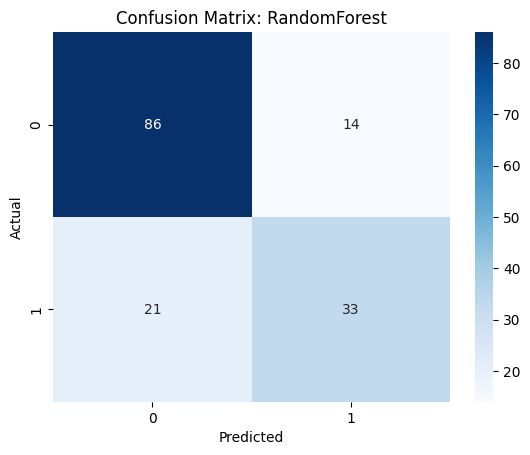

In [ ]:
# Show classification report & confusion matrix for best model
best_model_name = results_df.loc[0, 'Model']
best_pipe = trained_pipelines[best_model_name]
y_pred_best = best_pipe.predict(X_test)
print("Best model:", best_model_name)
print("\nClassification Report:\n", classification_report(y_test, y_pred_best))
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix: {best_model_name}')
plt.show()

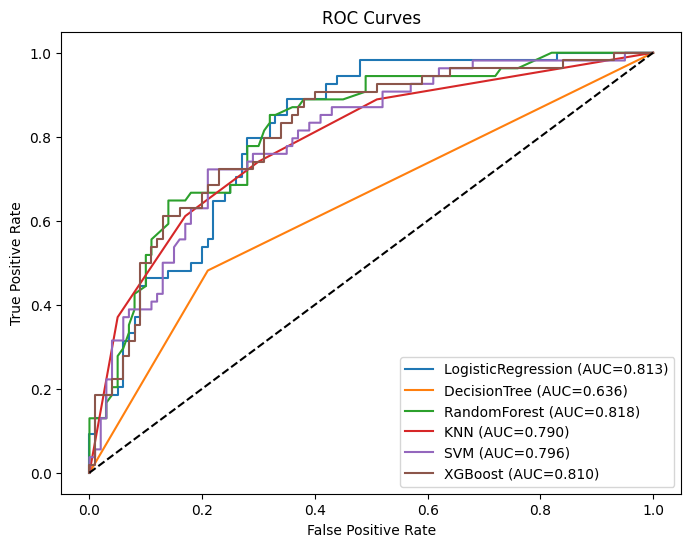

In [ ]:
plt.figure(figsize=(8,6))
for name, pipe in trained_pipelines.items():
    # get probabilities (or score)
    if hasattr(pipe.named_steps['classifier'], "predict_proba"):
        y_proba = pipe.predict_proba(X_test)[:,1]
    else:
        try:
            dfun = pipe.decision_function(X_test)
            y_proba = (dfun - dfun.min()) / (dfun.max() - dfun.min())
        except:
            continue
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc(fpr,tpr):.3f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

In [ ]:
# 8. CROSS-VALIDATION EXAMPLE
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
pipe_rf = Pipeline(steps=[('preprocessor', preprocessor), ('rf', rf)])
scores = cross_val_score(pipe_rf, X, y, cv=cv, scoring='roc_auc')
print("RandomForest CV ROC-AUC scores:", scores)
print("Mean ROC-AUC:", scores.mean())

RandomForest CV ROC-AUC scores: [0.83712963 0.8262037  0.83277778 0.81839623 0.78792453]
Mean ROC-AUC: 0.8204863731656186


In [ ]:
# 9. GRID SEARCH (hyperparameter tuning)
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'rf__n_estimators': [100, 200, 300, 400, 500],
    'rf__max_depth': [5, 10, 15, 20, None],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__max_features': ['sqrt', 'log2']
}

search = RandomizedSearchCV(
    pipe_rf,
    param_distributions=param_dist,
    n_iter=25,          # Try only 25 random combos
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42,
    verbose=1
)
search.fit(X, y)
print("Best params:", search.best_params_)
print("Best ROC-AUC:", search.best_score_)



Fitting 3 folds for each of 25 candidates, totalling 75 fits
Best params: {'rf__n_estimators': 500, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 4, 'rf__max_features': 'sqrt', 'rf__max_depth': 5}
Best ROC-AUC: 0.838969881484568


In [ ]:
# After hyperparameter tuning completes
print("\nHyperparameter tuning completed!")

# Get the best tuned model and its ROC-AUC score
best_model_name = 'RandomForest'  # or whichever model you tuned
best_roc_auc = grid.best_score_   # from your GridSearchCV results
best_pipeline = grid.best_estimator_

print(f"Improved best model: {best_model_name}")
print(f"Improved ROC-AUC score: {best_roc_auc:.3f}")



Hyperparameter tuning completed!
Improved best model: RandomForest
Improved ROC-AUC score: 0.837


In [ ]:
# 11. SAVE BEST TUNED MODEL
best_name = 'RandomForest'  # replace with the tuned model name
best_pipeline = grid.best_estimator_  # use best tuned version
joblib.dump(best_pipeline, 'best_diabetes_model.pkl')

print(f"✅ Saved best tuned model as best_diabetes_model.pkl (Model: {best_name})")
print(f"ROC-AUC of tuned model: {grid.best_score_:.3f}")


✅ Saved best tuned model as best_diabetes_model.pkl (Model: RandomForest)
ROC-AUC of tuned model: 0.837


                    feature  importance
1                   Glucose    0.174675
5                       BMI    0.117532
7                       Age    0.090909
6  DiabetesPedigreeFunction    0.062338
0               Pregnancies    0.052273
4                   Insulin    0.034740
2             BloodPressure    0.034091
3             SkinThickness    0.024026


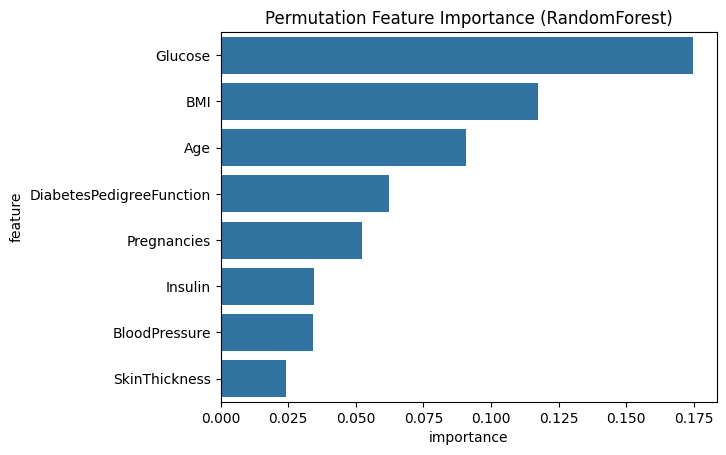

                    feature      coef  abs_coef
1                   Glucose  1.182567  1.182567
5                       BMI  0.688652  0.688652
0               Pregnancies  0.377446  0.377446
6  DiabetesPedigreeFunction  0.233337  0.233337
7                       Age  0.147794  0.147794
4                   Insulin -0.066119  0.066119
2             BloodPressure -0.044111  0.044111
3             SkinThickness  0.028321  0.028321


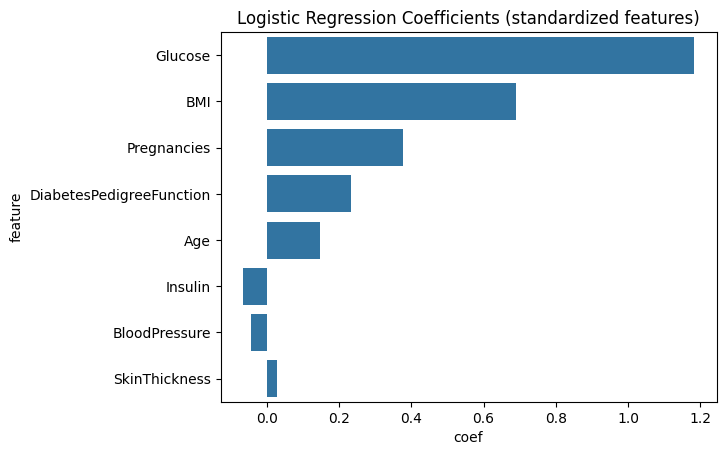

In [ ]:
# 10. FEATURE IMPORTANCE for tree-based (RandomForest) and coefficients for Logistic Regression
# RandomForest importance (permutation importance gives better model-agnostic view)

rf_pipe = best_pipeline  # use the tuned RandomForest model
if rf_pipe is not None:
    r = permutation_importance(rf_pipe, X_test, y_test, n_repeats=20, random_state=42, n_jobs=-1)
    feat_importances = pd.DataFrame({'feature': X.columns, 'importance': r.importances_mean})
    feat_importances = feat_importances.sort_values('importance', ascending=False)
    print(feat_importances)
    sns.barplot(x='importance', y='feature', data=feat_importances)
    plt.title('Permutation Feature Importance (RandomForest)')
    plt.show()

# Logistic Regression coefficients
lr_pipe = trained_pipelines.get('LogisticRegression', None)
if lr_pipe is not None:
    # get coefficients after scaling: meaning is standardized
    coef = lr_pipe.named_steps['classifier'].coef_[0]
    features = X.columns
    coef_df = pd.DataFrame({'feature': features, 'coef': coef})
    coef_df['abs_coef'] = coef_df['coef'].abs()
    coef_df = coef_df.sort_values('abs_coef', ascending=False)
    print(coef_df)
    sns.barplot(x='coef', y='feature', data=coef_df)
    plt.title('Logistic Regression Coefficients (standardized features)')
    plt.show()


In [ ]:
pip install streamlit

In [ ]:
from google.colab import files
files.download('best_diabetes_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>